In [14]:
%load_ext autoreload
%autoreload 2
from final_project.models import run_model
from final_project.models import save_model_pkl
from final_project.models import load_model
from final_project.models import plot_frequencies
import final_project.plots as plots
from final_project import builder
from final_project.loader import get_df
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

print(torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


In [15]:
# master_df = get_df(year="2018")
master_df = get_df(all_files=True)
master_df = master_df[master_df['Origin'] == 'BOS']
master_df = master_df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
master_df = builder.encodeFrame(master_df)

,DistanceGroup,ArrDel15,DistanceGroup,WeatherDelay,NASDelay,SecurityDelay,date_sin,date_cos,month_sin,month_cos,...,Dest_SLC,Dest_SMF,Dest_SRQ,Dest_STL,Dest_STT,Dest_SYR,Dest_TPA,Dest_TVC,Dest_TYS,Dest_VPS
726,6,0.0,6,0.0,0.0,0.0,0.998717,-0.050649,0.5,0.866025,...,0,0,0,0,0,0,0,0,0,0
727,6,0.0,6,0.0,0.0,0.0,0.968077,-0.250653,0.5,0.866025,...,0,0,0,0,0,0,0,0,0,0
728,6,0.0,6,0.0,0.0,0.0,0.897805,-0.440394,0.5,0.866025,...,0,0,0,0,0,0,0,0,0,0
729,6,1.0,6,0.0,15.0,0.0,0.790776,-0.612106,0.5,0.866025,...,0,0,0,0,0,0,0,0,0,0
730,6,0.0,6,0.0,0.0,0.0,0.651372,-0.758758,0.5,0.866025,...,0,0,0,0,0,0,0,0,0,0


# samples: 512522
train:
 - Number of features:  119
 - Number of samples:  256261
[207814  48447]


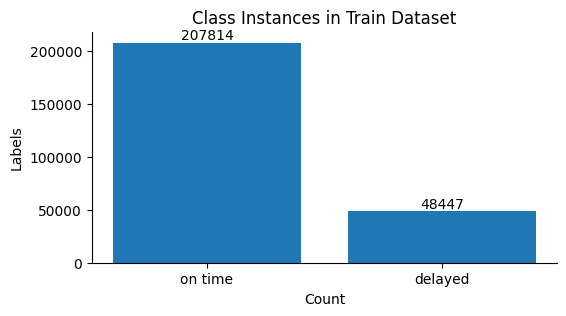


test:
 - Number of features:  119
 - Number of samples:  128130
[104008  24122]


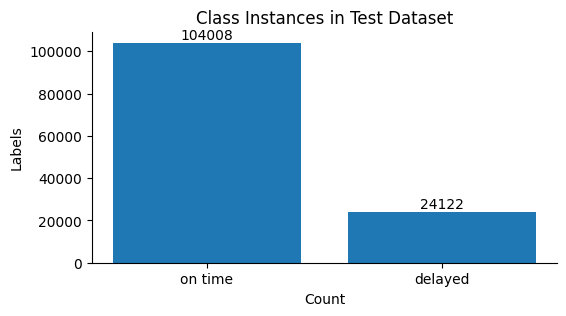


validation:
 - Number of features:  119
 - Number of samples:  128131
[104164  23967]


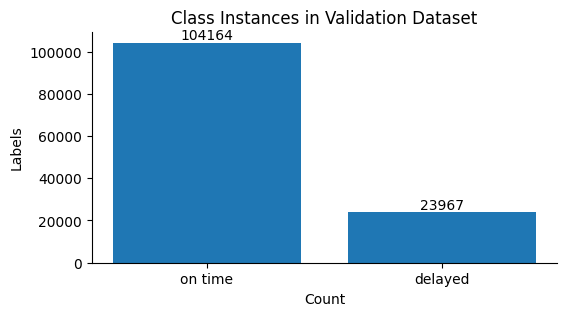

In [16]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_frequencies(each, (unique, counts))
    print()

In [17]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [18]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)
num_features=X_train.shape[1] 

using:  cpu


100%|██████████| 50/50 [09:49<00:00, 11.78s/it]

best loss:  0.24837099015712738
+---------------------------+---------+
| Hyperparameter            |   Value |
+===========================+=========+
| Best batch size:          | 64      |
+---------------------------+---------+
| Best epoch:               | 50      |
+---------------------------+---------+
| Best learning rate:       |  0.01   |
+---------------------------+---------+
| Best num nodes:           | 90      |
+---------------------------+---------+
| Best num layers:          |  4      |
+---------------------------+---------+
| Best momentum:            |  0.09   |
+---------------------------+---------+
| Best weight decay:        |  0.0001 |
+---------------------------+---------+
| Best dropout probability: |  0.5    |
+---------------------------+---------+


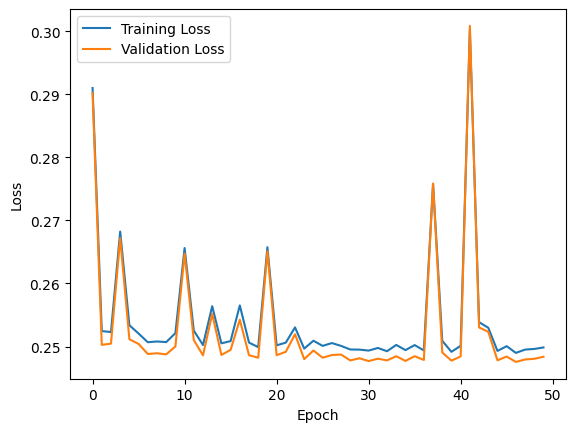

Evaluating **train** dataset:
using:  cpu


100%|██████████| 4005/4005 [00:03<00:00, 1215.65it/s]


Mean Accuracy: 92.550
Mean per-class accuracy:
  on time: 100.000%
  delayed: 60.592%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    207814
         1.0       1.00      0.61      0.75     48447

    accuracy                           0.93    256261
   macro avg       0.96      0.80      0.86    256261
weighted avg       0.93      0.93      0.92    256261

[[207814      0]
 [ 19092  29355]]

Evaluating **test** dataset:
using:  cpu


100%|██████████| 2003/2003 [00:01<00:00, 1221.77it/s]


Mean Accuracy: 92.686
Mean per-class accuracy:
  on time: 100.000%
  delayed: 61.148%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    104008
         1.0       1.00      0.61      0.76     24122

    accuracy                           0.93    128130
   macro avg       0.96      0.81      0.86    128130
weighted avg       0.93      0.93      0.92    128130

[[104008      0]
 [  9372  14750]]

Evaluating **validation** dataset:
using:  cpu


100%|██████████| 2003/2003 [00:01<00:00, 1230.83it/s]


Mean Accuracy: 92.625
Mean per-class accuracy:
  on time: 100.000%
  delayed: 60.571%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    104164
         1.0       1.00      0.61      0.75     23967

    accuracy                           0.93    128131
   macro avg       0.96      0.80      0.86    128131
weighted avg       0.93      0.93      0.92    128131

[[104164      0]
 [  9450  14517]]



In [19]:
params = {"bs":(64,),
        "epoch":(50,),
        "learning_rate":(.01,),
        "momentum":(.09,),
        "weight_decay":(.0001,),
        "activation_fn": nn.ReLU,
        "dropout_prob": (.5,),
        "num_layers": (4,),
        "num_nodes": (90,)}
best_model_params, best_model = run_model(param_dict=params, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  valid_ds=valid_ds,
                  num_features=num_features
                  )

using:  cpu


100%|██████████| 2003/2003 [00:02<00:00, 952.40it/s] 


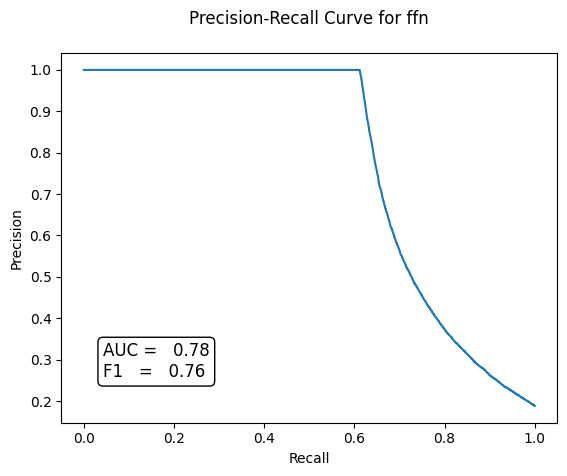

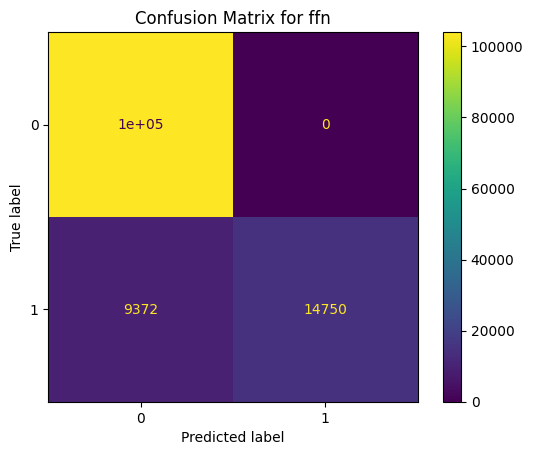

In [22]:
ground_truth_labels, y_prob, y_pred = best_model.predict(test_ds)
plots.save_precision_recall_curve("ffn", "ffn_4_90_prec_rec_curve", ground_truth_labels, y_prob)
plots.save_confusion_matrix("ffn", "ffn_4_90_confusion", ground_truth_labels, y_pred)


In [21]:
save_model_pkl(best_model_params)